Measure Coulomb Blocking by sweeping ST using RF by the SHFQC and Toolkit

**Spectroscopy or Readout mode?**
It appears that while spectroscopy can be used for different parameter sweeps, it is best used for frequency sweeps. Readout mode is more versitile in our case and should be used

See https://docs.zhinst.com/shfqc_user_manual/tutorials/tutorial_qubit_readout.html for a base guide on which this notebook was made. In particular see https://github.com/zhinst/zhinst-toolkit/blob/main/examples/shfqa_qubit_readout_measurement.md


**THIS ONLY WORKS FOR RF AND NOT LF.**
No idea why. It is probably a bug. In LF the pulse is a simple square and the oscillator is ignored

In [1]:
%matplotlib inline
import local_broom

Added 'quench/' and 'quench/libraries' for easy importing.


In [2]:
from zhinst.toolkit import Session, CommandTable, Sequence, Waveforms, SHFQAChannelMode

import matplotlib.pyplot as plt
import numpy as np
from tqdm.autonotebook import tqdm

import time
from monty import Monty

C:\Users\LD2007\AppData\Local\Temp\ipykernel_26308\652053071.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# connect to instruments

DEVICE_ID = 'DEV12158'
SERVER_HOST = 'localhost'

# connect to data server
session = Session(SERVER_HOST)

# connect to device
device = session.connect_device(DEVICE_ID)

In [60]:
session.disconnect_device(DEVICE_ID)

In [4]:
# Create channel maps for simplicity

chan = {
    "measure": device.qachannels[0],  # measure and acquire lines
    "ST": device.sgchannels[5],  # drive SET (ST) line
}

drive_chans = ["ST"]  # match keys above

## Setup SG Channels

In [61]:
with device.set_transaction():
    for c in drive_chans:
        chan[c].output.range(5)  # in dBm
        chan[c].output.rflfpath(0)  # use LF not RF (1 for RF)
    
        chan[c].output.on(1)  # enable the channel (rememeber to disable it later)

        # set the center synth frequency (oscillator frequency)
        synth = chan[c].synthesizer()
        device.synthesizers[synth].centerfreq(0)  # in Hz
    
        chan[c].awg.outputamplitude(1.0)  # overall amplitude scaling factor (don't really need to change)
        chan[c].oscs[0].freq(0)  # oscillator 1 frequency (Hz) disable for DC
        chan[c].oscs[1].freq(0)  # oscillator 2 frequency (Hz)
        chan[c].awg.modulation.enable(1)  # start digital modulation
    
        #chan[c].marker.source(0)  # setup the AWG trigger 1
        chan[c].awg.auxtriggers[0].channel(8)  # 8 = use internal trigger

DeviceNotFoundError: ZIAPIServerException with status code: 32795 - Device not found. Extended information: Device DEV12158 is not connected to the data-server. Did you call connectDevice?

In [6]:
seq = Sequence()
seq.code = """
wave w_a = ones(1024);

// Assign a single channel waveform to wave table entry 0
assignWaveIndex(1,2, w_a, 0);

 repeat(100) {
        waitDigTrigger(1);

        setTrigger(1);
        setTrigger(0);
       executeTableEntry(0);
       
    }
"""

chan["ST"].awg.load_sequencer_program(seq)

{'messages': '', 'maxelfsize': 2147483648}

In [7]:
# setup drive command tables

ct_schema = chan["ST"].awg.commandtable.load_validation_schema()
ct = CommandTable(ct_schema)

gain = 1.0

ct.table[0].waveform.index = 0
ct.table[0].amplitude00.value = gain
ct.table[0].amplitude10.value = gain
ct.table[0].amplitude01.value = -gain
ct.table[0].amplitude11.value = gain
# ct.table[0].waveform.samplingRateDivider = 0  # 2^X divider
#ct.table[0].waveform.length = 10240
#ct.table[0].waveform.playHold = True

chan["ST"].awg.commandtable.upload_to_device(ct)

## Setup QA Channels

In [49]:
with device.set_transaction():
    chan["measure"].output.rflfpath(1)  # use LF mode not RF (for signals under 600Mhz)
    chan["measure"].input.rflfpath(1)
    #chan["measure"].output.digitalmixer.centerfreq(400e6)  # only applicable for RF mode (otherwise forced to 0Hz)
    #chan["measure"].centerfreq(0)  # in Hz (appears to be ignored when in LF mode. immutable?)
    chan["measure"].oscs[0].freq(406.6e6)  # CW frequency (in LF mode)
    chan["measure"].oscs[0].gain(1.0)

    # temporarily disabled based on tutorial
    #chan["measure"].generator.auxtriggers[0].channel(8)  # use internal trigger
    #chan["measure"].generator.enable(0)  # do not run yet

    # no longer use spectroscopy mode. use readout instead
    #chan["measure"].spectroscopy.delay(220e-9)  # integration delay in units of second
    #chan["measure"].spectroscopy.length(1024)  # integration length in units of number of samples
    #chan["measure"].spectroscopy.result.averages(1)  # number of averages 
    #chan["measure"].spectroscopy.result.enable(0) # disable result logger
    #chan["measure"].spectroscopy.result.length(4096)

    #chan["measure"].input.range(0)
    #chan["measure"].output.range(-5)
    #chan["measure"].input.on(1)
    #chan["measure"].output.on(1)

    chan["measure"].configure_channel(
        center_frequency=0,  # in units of Hz  # minimum of 600MHz
        input_range=-10,  # in units of dBm
        output_range=-20,  # in units of dBm
        mode=SHFQAChannelMode.READOUT,  # SHFQAChannelMode.READOUT or SHFQAChannelMode.SPECTROSCOPY
    )
    
    chan["measure"].input.on(1)
    chan["measure"].output.on(1)

    # temporarily disable based on tutorial
    #chan["measure"].generator.configure_sequencer_triggering(
    #    aux_trigger=8,  # internal trigger
    #    play_pulse_delay=0,  # 0s delay between startQA trigger and the readout pulse
    #)

In [17]:
# setup Waveform pulses

readout_pulses = Waveforms()
readout_pulses.assign_waveform(
    slot=0,
    wave1=np.ones(2048),  # assumes 0 for wave2
)

chan["measure"].generator.write_to_waveform_memory(readout_pulses)

In [39]:
for i,j in readout_pulses.items():
    print(i, j)

0 (Wave([1., 1., 1., ..., 1., 1., 1.]), None, None)


In [18]:
# setup weights for integration

ROTATION_ANGLE = 0

# for this demo simply use the same envelope profile as the readout pulses
weights = Waveforms()

for waveform_slot, pulse in readout_pulses.items():
    weights.assign_waveform(
        slot=waveform_slot,
        wave1=np.conj(pulse[0] * np.exp(1j * ROTATION_ANGLE))
    )

chan["measure"].readout.write_integration_weights(weights=weights, integration_delay=200e-9)  # compensate for delay between generater output and input of the integrator

In [19]:
# setup the result logger
NUM_READOUTS = 100

chan["measure"].readout.configure_result_logger(result_length=NUM_READOUTS, result_source="result_of_integration")

In [31]:
# configure the sequencer for the readout pulses

# Sequencer waits for the trigger, then starts the readout, then repeats this for the chosen number of readouts

chan["measure"].generator.configure_sequencer_triggering(
    aux_trigger="software_trigger0",
    play_pulse_delay=0
)

seq = Sequence()
seq.code = f"""
repeat ({NUM_READOUTS}) {{

    // wait for a digital trigger before starting
    waitDigTrigger(1);

    setTrigger(1);
    //playZero(16000);
    setTrigger(0);

    startQA(QA_GEN_ALL, QA_INT_ALL, true, 0, 0x0);

    // legacy. only useful in RF mode when we are triggering pulses. For some reason this doens't seem to work in LF mode
    // play readout waveform stored in Waveform Memory slot 1,
    // send a trigger to start integration,
    // and send a Sequencer Monitor trigger to trigger the Scope 
    //startQA(QA_GEN_0, QA_INT_0, true);
}}

"""

chan["measure"].generator.load_sequencer_program(seq)

{'messages': '', 'maxelfsize': 2147483648}

## Run the experiment

In [56]:
# the new method using readout instead of spectroscopy
chan["measure"].readout.run()  # start readout data logger
chan["measure"].generator.enable_sequencer(single=True)  # start the QA sequencer (it halts until receiveing a digital trigger)

device.start_continuous_sw_trigger(num_triggers=NUM_READOUTS, wait_time=2e-3)


In [57]:
# get the results
res = chan["measure"].readout.read()

In [58]:
res.shape

(8, 100)

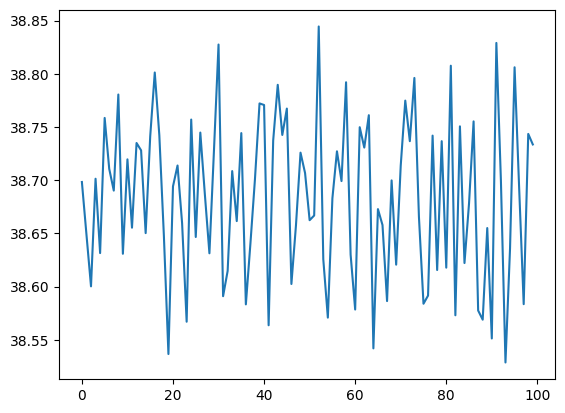

In [59]:
plt.plot(np.abs(res[0,:]))

In [11]:
# the old way of doing things
def get_results(result_node, timeout):
    wave_data_captured = {}
    wave_data_captured[result_node] = False
    start_time = time.time()
    captured_data = {}
    while not all(wave_data_captured.values()):
        if start_time + timeout < time.time():
            print(captured_data)
            raise TimeoutError('Timeout before all samples collected.')
        test = session.poll()
        for node, value in test.items():
            node = session.raw_path_to_node(node)
            for v in value:
                if node not in captured_data:
                    captured_data[node] = [v['vector']]
                else:
                    captured_data[node].append(v['vector'])
            if len(captured_data[node]) >= 1:  # readout 1 point
                wave_data_captured[node] = True
                total_num_data = sum([len(element) for element in captured_data[node]])
    data = captured_data[result_node][0]
    return data

In [12]:
device.system.internaltrigger.repetitions(1)  # make sure that this matches how many repetitions for each awg sequencer
device.system.internaltrigger.holdoff(100e-6)

In [13]:
result_node = chan["measure"].spectroscopy.result.data.wave
result_node.subscribe()

# Start a measurement
#device.scopes[0].run(single=True)  # start acquisition listener
chan["ST"].awg.enable(1)  # start DC driver
#chan["measure"].generator.enable_sequencer(single=True)  # start RF measurement
chan["measure"].generator.enable(1)
chan["measure"].spectroscopy.result.enable(1)  # enable result logger
device.system.internaltrigger.enable(1)  # trigger all sequencers simultaniously
chan["measure"].spectroscopy.result.enable(0)
results = get_results(result_node, 5) # get results
result_node.unsubscribe()

In [14]:
results[:10]

array([-5.07519181e-03-1.89849930e-02j, -5.07600280e-03-1.91087741e-02j,
       -6.99672992e-03-3.38588545e-02j,  0.00000000e+00+0.00000000e+00j,
        3.92160380e+08+0.00000000e+00j,  1.74154193e-07+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+1.19677850e+04j,
        0.00000000e+00+7.47986587e+02j,  8.50362272e-11+0.00000000e+00j])

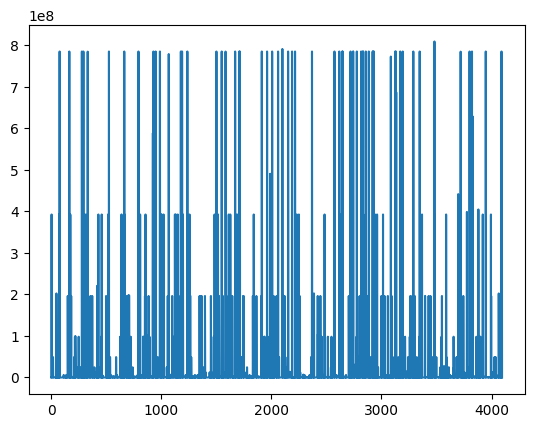

In [15]:
plt.plot(np.abs(results))